# Berkeley Single Cell Computational Microscopy (BSCCM) dataset

In [1]:
%load_ext autoreload
%autoreload 2

from bsccm import BSCCM
from pathlib import Path

home = str(Path.home())
data_root = home + '/BSCCM_local/BSCCM-tiny/'

dataset = BSCCM(data_root)

## Dataset overview

In [ ]:
What formats are all the data stored in in
    global metadata in json
    index (i.e. metadata for each cell) stored in csv read by pandas
    image data stored in data
        individual 0.0.0 files are chunks correspondign to each channel
            probably stored in zarr

Explain folder structure
    antiodie -- show figure
        the rows correspond to physical slides on the microscope
        like each slide is a single experiment with 0, 1, or 8 antibodies as indicated
        all ==> all 8 antibodies
        unstained ==> no antibodies
        CD45 ==> the CD45 antibody only
        batch refers to that I did this entire chart twice
            yeah different cells but sourced from same populationon same day
    batch -- 1 or two
    replicate -- a small number have two slides
            

like if cell_1 is under CD123 folder, it will not show up in any other folder because that unique cell was only on 1 slide
the global index appears after cell_
    I see the dpc folder has 1 image per cell. 
    fluor folder has 6 images per cell (6 emission channels? what was the wavelength)
    and led array has 23 images (different illumination conditions as shown in the demo).

More details about LEDs and spectra
Knightbright APTF1616SEEZGQBDC datasheet


was histology not done for all 20 slides?
don’t see an explicit histology folder
no only a tiny subset
2 slides, small number of cells
~15k total histology cells
compared to something like 412k total cells 

do you remember which batch and which slide? or how do I find the raw images in the folder set

[remake this code snippet and watch index numbers]
histology_dataframe = dataset.dataframe.iloc[dataset.get_indices(has_matched_histology=True)]
print(histology_dataframe.batch.unique(), histology_dataframe.marker.unique(),
      histology_dataframe.replicate.unique())
gives the result: [1. 2.] [‘unstained’] [1 2]
    i.e. unstained, batch 1, replicate 1, and unstained batch 2 replicate 2
[these numbers change i think]


try typing: dataset.dataframe into a cell in the notebook and it will pop up the index with all sorts of data

effectively all the methods of the bsbcm are just querying that dataframe, which is the CSV file, and contains all of the information (i.e. you never need to look at the folders directly)

the dataframe is a pandas Dataframe object. pandas is a popular package for manipulating tabular data that it would be worthwhile to learn a bit of


Gotchas/limitsations
    Batch 1 CD19 antbody concentration is 35% of all others
    Those LEDs are missing in BSCCM cohernet
    Not great seperation of the fluorophores
    Fieldstop slightly off on that batch 2 one
    

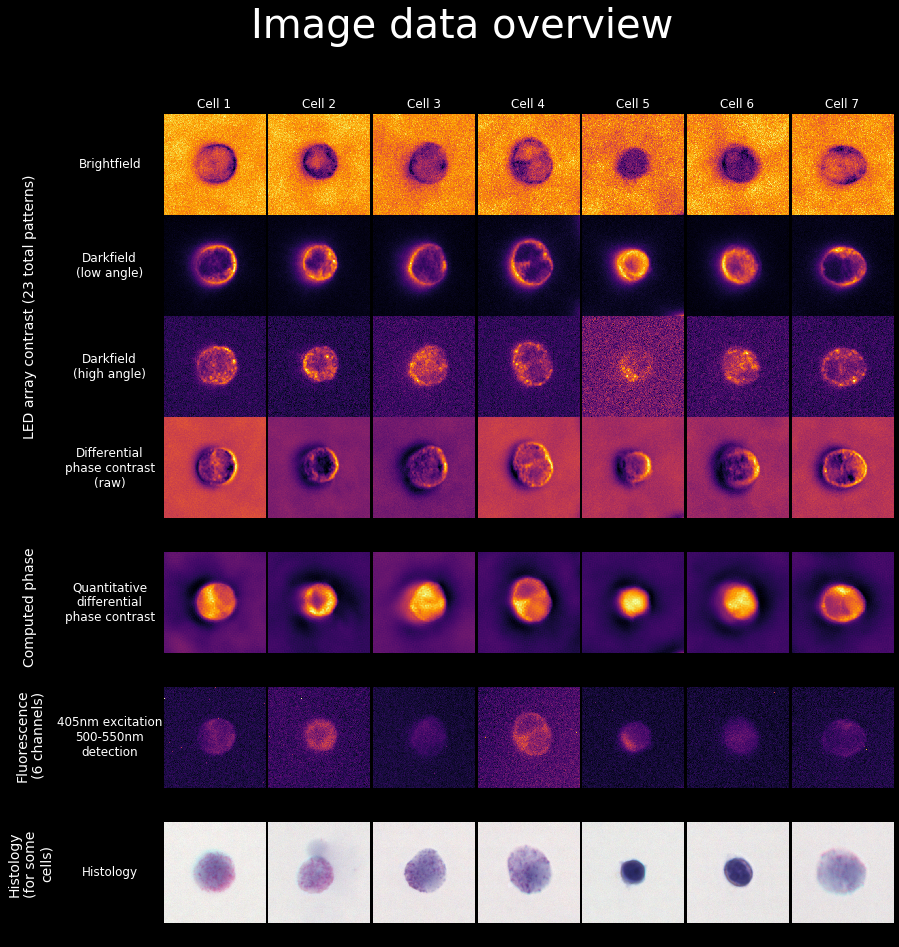

In [9]:
from led_array_calibration import plot_led_pattern
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches


num_cols = 8
cell_indices = dataset.get_indices(has_matched_histology=True, shuffle=True)[:num_cols - 1]

contrast_types = ['led_array', 'led_array', 'led_array', 'led_array', 'dpc', 'fluor', 'histology']
channels = ['Brightfield', 'DF_50', 'DF_80', 'DPC_Left', None, 'F5_BV510', None]
channel_display = ['Brightfield', 'Darkfield\n(low angle)',
                   'Darkfield\n(high angle)', 'Differential\nphase contrast\n(raw)',
                   'Quantitative\ndifferential\nphase contrast', '405nm excitation\n500-550nm\ndetection', 'Histology']


num_rows = 7
gs = gridspec.GridSpec(2, num_cols, wspace=0., hspace=0.)
gs_top = gs[0, :].subgridspec(4, num_cols, wspace=0., hspace=0.)
gs_bottom = gs[1, :].subgridspec(12, num_cols, wspace=0., hspace=0.)

fig = plt.figure(figsize=(15, num_rows / num_cols * 17))
fig.set_facecolor('black')
for i in range(num_rows):
    if i < 4:
        gs = gs_top
        ax = plt.subplot(gs[i, 0], facecolor='black')
    else:
        gs = gs_bottom
        ax = plt.subplot(gs[1 + 4*(i - 4):4*(i - 3), 0], facecolor='black')
    
    ax.text(0.5, 0.5, channel_display[i], horizontalalignment='center', verticalalignment='center',
                color='white', size=12)
        
    for j, index in enumerate(cell_indices):
        img = dataset.read_image(index=index, contrast_type=contrast_types[i], channel=channels[i])
        if i < 4:
            ax = plt.subplot(gs[i % 4, 1 + j], facecolor='black')
        else:
            ax = plt.subplot(gs[1 + 4 * (i - 4):4 + 4 * (i - 4), 1 + j], facecolor='black')
        ax.set_axis_off()
        if contrast_types[i] == 'histology':
            ax.imshow(img / (2 ** 12))
        else:
            ax.imshow(img, cmap='inferno')

        if i == 0:
            ax.set_title('Cell {}'.format(j + 1), color='white')
        
#Add labels
fig.text(0.1, 0.7, 'LED array contrast (23 total patterns)', 
         horizontalalignment='center', verticalalignment='center',
         rotation='vertical', color='white', size=14)
fig.text(0.1, 0.42, 'Computed phase', 
         horizontalalignment='center', verticalalignment='center',
         rotation='vertical', color='white', size=14)
fig.text(0.1, 0.3, 'Fluorescence\n(6 channels)', 
         horizontalalignment='center', verticalalignment='center',
         rotation='vertical', color='white', size=14)
fig.text(0.1, 0.18, 'Histology\n(for some\ncells)', 
         horizontalalignment='center', verticalalignment='center',
         rotation='vertical', color='white', size=14)
_ = fig.suptitle('Image data overview', color='white', size=40)
plt.savefig('figures/data_overview.pdf', facecolor='black')

## Show an image of a random cell in quantitative differential phase contrast

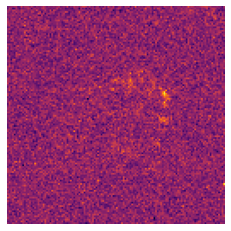

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# random_index = np.random.choice(np.arange(dataset.size))
random_index = 4
image = dataset.read_image(random_index, contrast_type='led_array', channel='led_400')
plt.figure()
plt.imshow(image, cmap='inferno')
plt.gca().set_axis_off()

In [11]:
dataset.global_metadata

{'led_array': {'channel_names': ['Brightfield',
   'DF_50',
   'DF_50_Bottom',
   'DF_50_Right',
   'DF_55',
   'DF_60',
   'DF_60_Bottom',
   'DF_60_Right',
   'DF_65',
   'DF_70',
   'DF_70_Bottom',
   'DF_70_Right',
   'DF_75',
   'DF_80',
   'DF_80_Bottom',
   'DF_80_Right',
   'DF_85',
   'DF_90',
   'DPC_Bottom',
   'DPC_Left',
   'DPC_Right',
   'DPC_Top',
   'LED119'],
  'channel_indices': {'Brightfield': 0,
   'DF_50': 1,
   'DF_50_Bottom': 2,
   'DF_50_Right': 3,
   'DF_55': 4,
   'DF_60': 5,
   'DF_60_Bottom': 6,
   'DF_60_Right': 7,
   'DF_65': 8,
   'DF_70': 9,
   'DF_70_Bottom': 10,
   'DF_70_Right': 11,
   'DF_75': 12,
   'DF_80': 13,
   'DF_80_Bottom': 14,
   'DF_80_Right': 15,
   'DF_85': 16,
   'DF_90': 17,
   'DPC_Bottom': 18,
   'DPC_Left': 19,
   'DPC_Right': 20,
   'DPC_Top': 21,
   'LED119': 22},
  'exposure_ms': {'Brightfield': 8,
   'DF_50': 29,
   'DF_50_Bottom': 58,
   'DF_50_Right': 58,
   'DF_55': 46,
   'DF_60': 62,
   'DF_60_Bottom': 124,
   'DF_60_Right'

## Show a montage of many random cells

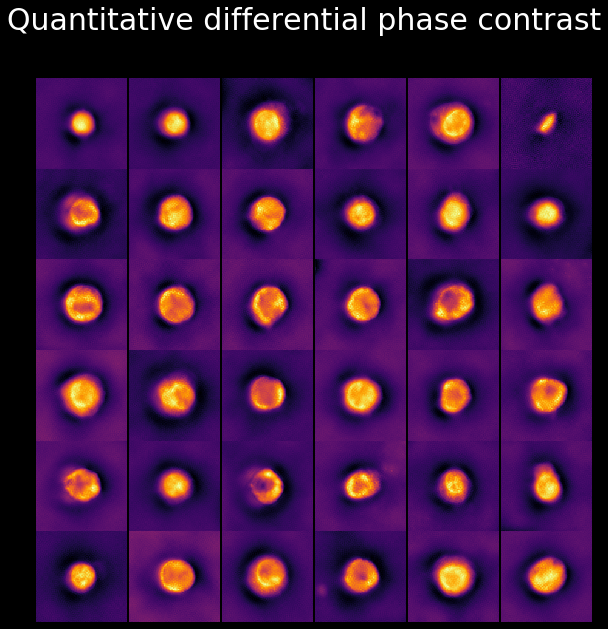

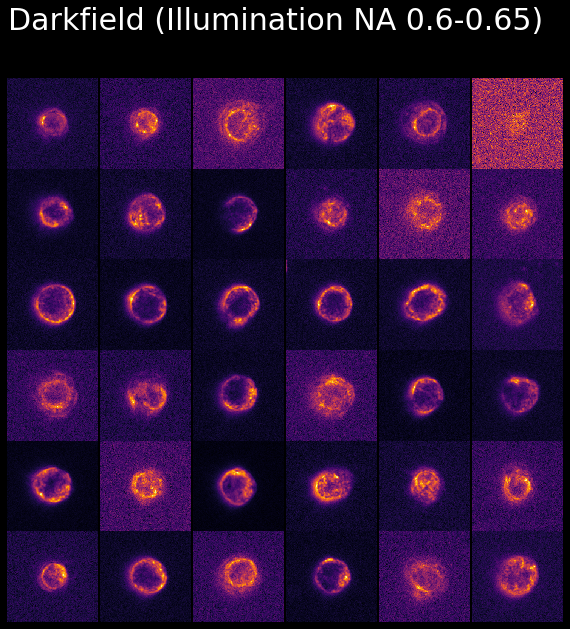

In [189]:
indices = np.random.choice(np.arange(dataset.size), size=36)

dataset.plot_montage(indices, contrast_type='dpc')
plt.gcf().suptitle('Quantitative differential phase contrast', fontsize=30, color='white')
plt.gcf().set_facecolor('black')
dataset.plot_montage(indices, contrast_type='led_array', channel='DF_60')
plt.gcf().suptitle('Darkfield (Illumination NA 0.6-0.65)', fontsize=30, color='white')
plt.gcf().set_facecolor('black')

## Plot a montage of cells with histology stain contrast

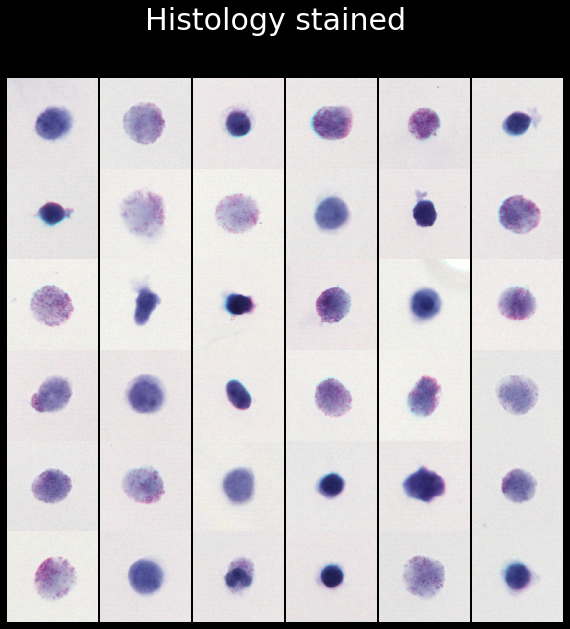

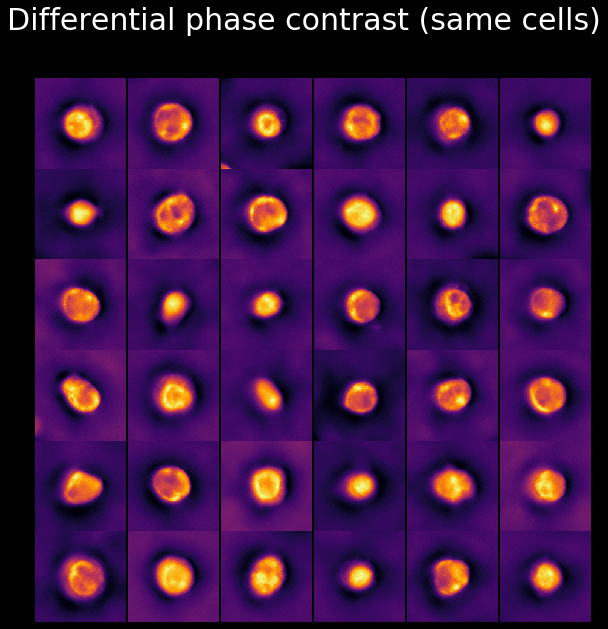

In [10]:
#Find a random set of indices for cells that have matched histology images
indices = dataset.get_indices(has_matched_histology=True, shuffle=True)[:36]
dataset.plot_montage(indices, contrast_type='histology')
plt.gcf().suptitle('Histology stained', fontsize=30, color='white')
plt.gcf().set_facecolor('black')
plt.savefig('figures/histology_montage.pdf', facecolor='black')

dataset.plot_montage(indices, contrast_type='dpc')
plt.gcf().suptitle('Differential phase contrast (same cells)', fontsize=30, color='white')
plt.gcf().set_facecolor('black')
plt.savefig('figures/dpc_montage.pdf', facecolor='black')

## LED array contrasts

In [28]:
# Print all available channels for LED array images
print('\n'.join(dataset.led_array_channel_names))

Brightfield
DF_50
DF_50_Bottom
DF_50_Right
DF_55
DF_60
DF_60_Bottom
DF_60_Right
DF_65
DF_70
DF_70_Bottom
DF_70_Right
DF_75
DF_80
DF_80_Bottom
DF_80_Right
DF_85
DF_90
DPC_Bottom
DPC_Left
DPC_Right
DPC_Top
LED119


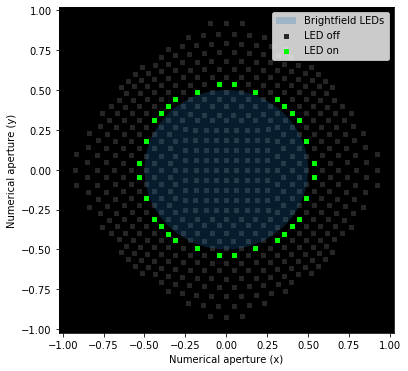

In [5]:
from led_array_calibration import plot_led_pattern, illumination_to_led_indices, get_led_na_xy, get_led_na

plt.figure(figsize=(6,6))
plot_led_pattern(channel_name='DF_50', size=20)

dpc_top_leds = illumination_to_led_indices('DPC_Top')

na_xy = get_led_na_xy(dpc_top_leds)
plt.savefig('figures/darkfield_led_pattern.pdf')

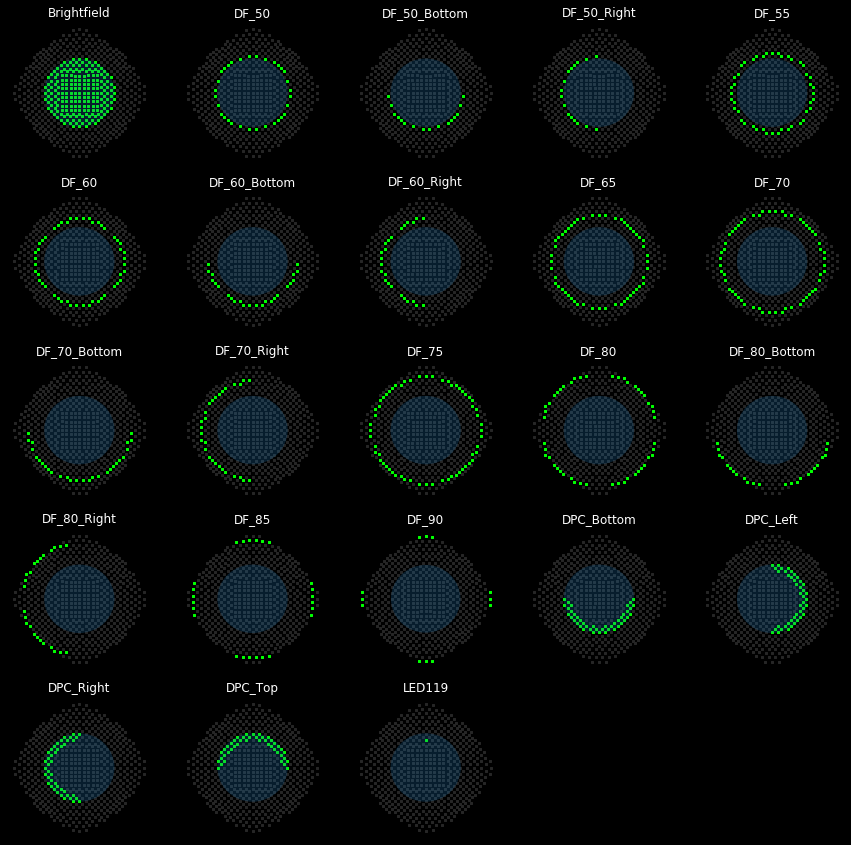

In [11]:
from led_array_calibration import plot_led_pattern
import matplotlib.pyplot as plt

channel_names = dataset.led_array_channel_names

fig = plt.figure(figsize=(15,15))
for i in range(23):
    ax = plt.subplot(5, 5, i + 1)
    plot_led_pattern(channel_name=channel_names[i], ax=ax, legend=False, size=8)
    ax.set_title(channel_names[i], color='white')
    ax.set_axis_off()
fig.set_facecolor('black')
plt.savefig('figures/all_led_patterns.pdf', facecolor='black')

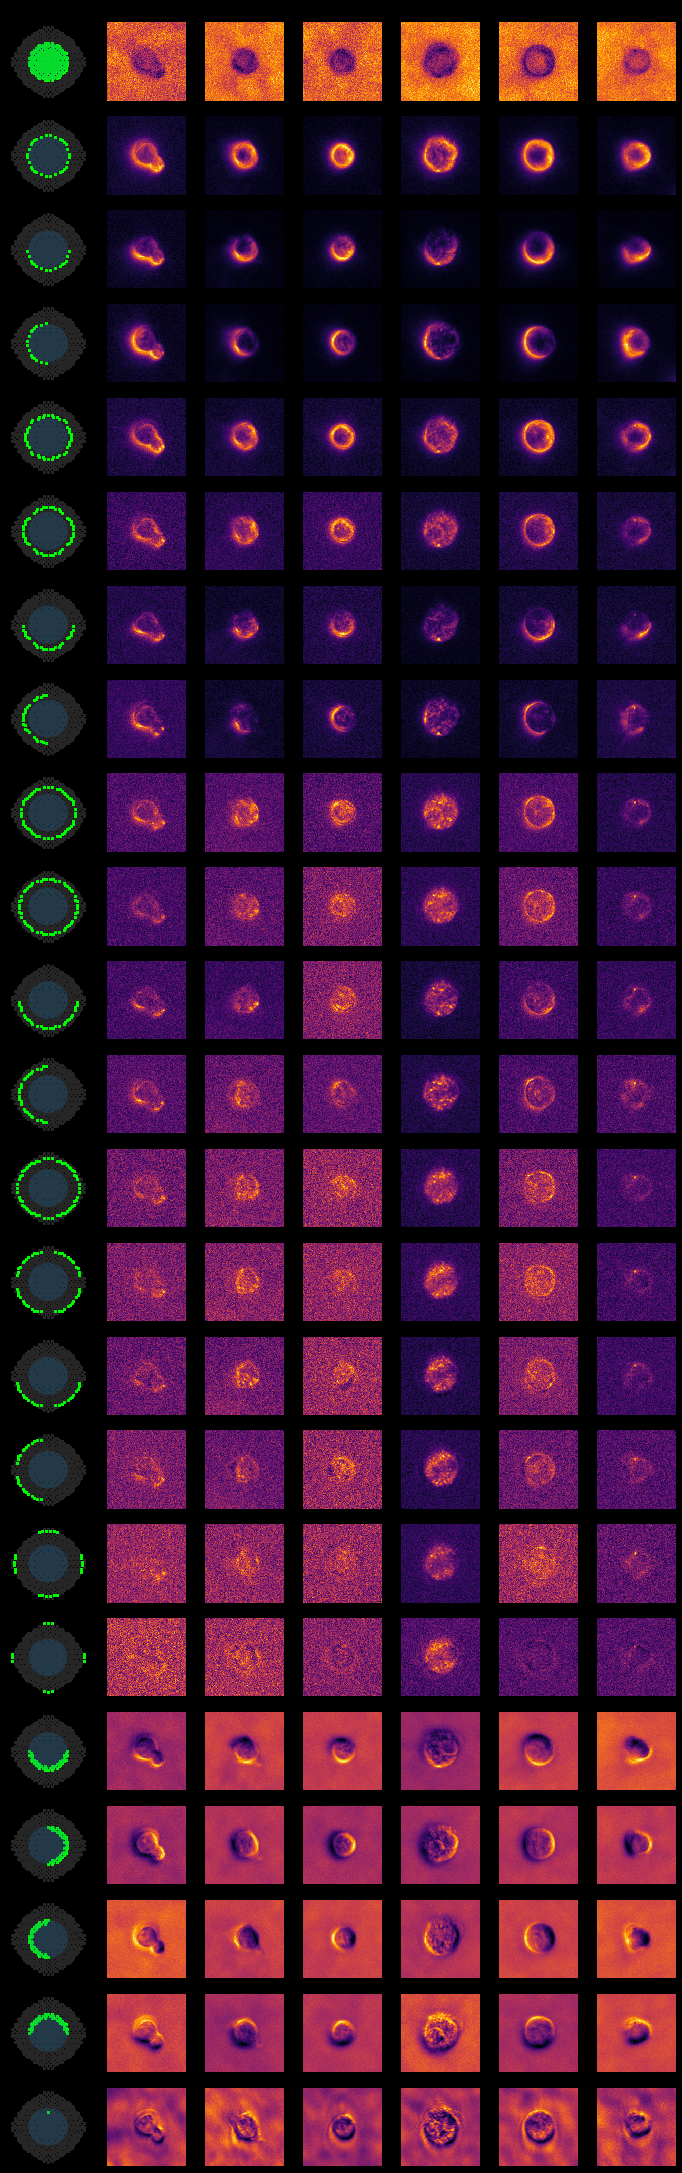

In [12]:
from led_array_calibration import plot_led_pattern
import matplotlib.pyplot as plt
import numpy as np

channel_names = dataset.led_array_channel_names

num_cols = 7
cell_indices = np.random.choice(np.arange(dataset.size), size=num_cols - 1)

fig = plt.figure(figsize=(12, 23 / num_cols * 12))
fig.set_facecolor('black')
for i in range(23):
    ax = plt.subplot(23, num_cols, i * num_cols + 1)
    plot_led_pattern(channel_name=channel_names[i], ax=ax, legend=False, size=8)
    ax.set_xlabel(channel_names[i], color='white')
    ax.set_axis_off()
    
    for j, index in enumerate(cell_indices):
        img = dataset.read_image(index=index, contrast_type='led_array', channel=channel_names[i])
        ax = plt.subplot(23, num_cols, i * num_cols + 2 + j)
        ax.imshow(img, cmap='inferno')
        ax.set_axis_off()
        if i == 0:
            ax.set_title('Cell {}'.format(j + 1))
plt.savefig('figures/patterns_and_images.pdf', facecolor='black')

## TODO: fluor channel names
The F1 indicates the order in which they were selected
TODO: add filter and illumination information

In [45]:
dataset.fluor_channel_names

['F1_BV711', 'F2_BV650', 'F3_BV605', 'F4_BV570', 'F5_BV510', 'F6_BV421']